C:\Users\AJ\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AJ\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 3.0862, Train Accuracy: 18.29%, Val Loss: 2.1785, Val Accuracy: 68.00%
Epoch [2/10], Train Loss: 1.8697, Train Accuracy: 57.43%, Val Loss: 1.0379, Val Accuracy: 92.44%
Epoch [3/10], Train Loss: 1.0799, Train Accuracy: 75.81%, Val Loss: 0.5610, Val Accuracy: 93.33%
Epoch [4/10], Train Loss: 0.7097, Train Accuracy: 85.24%, Val Loss: 0.3872, Val Accuracy: 95.56%
Epoch [5/10], Train Loss: 0.4815, Train Accuracy: 89.81%, Val Loss: 0.2468, Val Accuracy: 96.89%
Epoch [6/10], Train Loss: 0.3745, Train Accuracy: 92.57%, Val Loss: 0.1563, Val Accuracy: 97.78%
Epoch [7/10], Train Loss: 0.2817, Train Accuracy: 94.29%, Val Loss: 0.1796, Val Accuracy: 96.00%
Epoch [8/10], Train Loss: 0.2460, Train Accuracy: 95.05%, Val Loss: 0.0839, Val Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.1834, Train Accuracy: 96.86%, Val Loss: 0.0798, Val Accuracy: 99.11%
Epoch [10/10], Train Loss: 0.1639, Train Accuracy: 96.38%, Val Loss: 0.0781, Val Accuracy: 99.11%


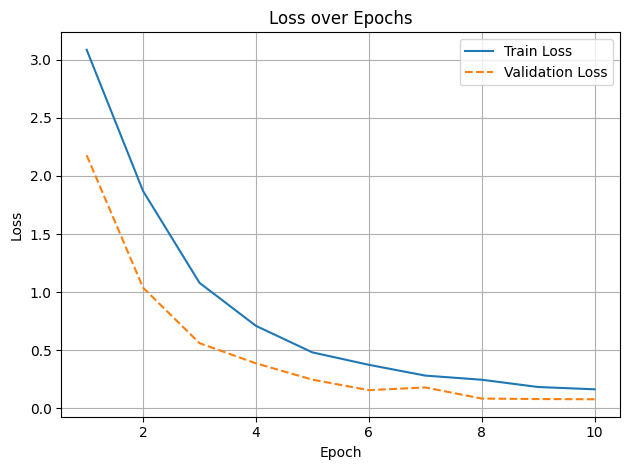

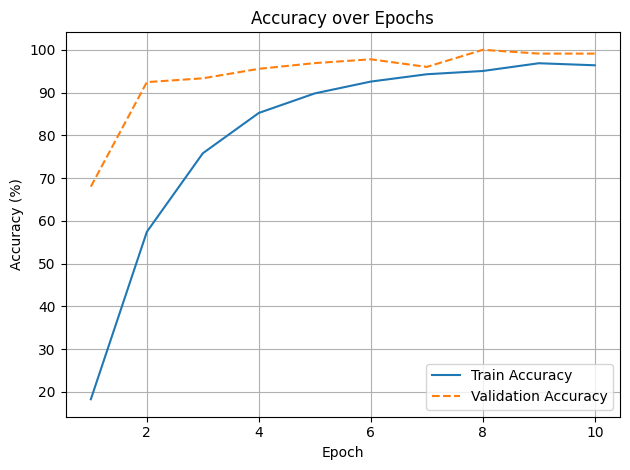


Test Accuracy: 98.22%

                               precision    recall  f1-score   support

                     Anusshar       1.00      1.00      1.00        13
                       Ba Bha       1.00      1.00      1.00         8
     Ba-y Ra Da-y Ra Dha-y Ra       1.00      1.00      1.00        11
                     Bisharga       1.00      1.00      1.00         6
             Borgio JaAnta Ja       1.00      1.00      1.00        11
                           Ca       0.89      0.89      0.89         9
                          Cha       1.00      0.89      0.94         9
                Chandra Bindu       1.00      1.00      1.00         7
                           Da       1.00      1.00      1.00        11
                          Dha       1.00      0.86      0.92         7
                           Ga       1.00      1.00      1.00         9
                          Gha       1.00      1.00      1.00         5
                           Ha       1.00      1.00  

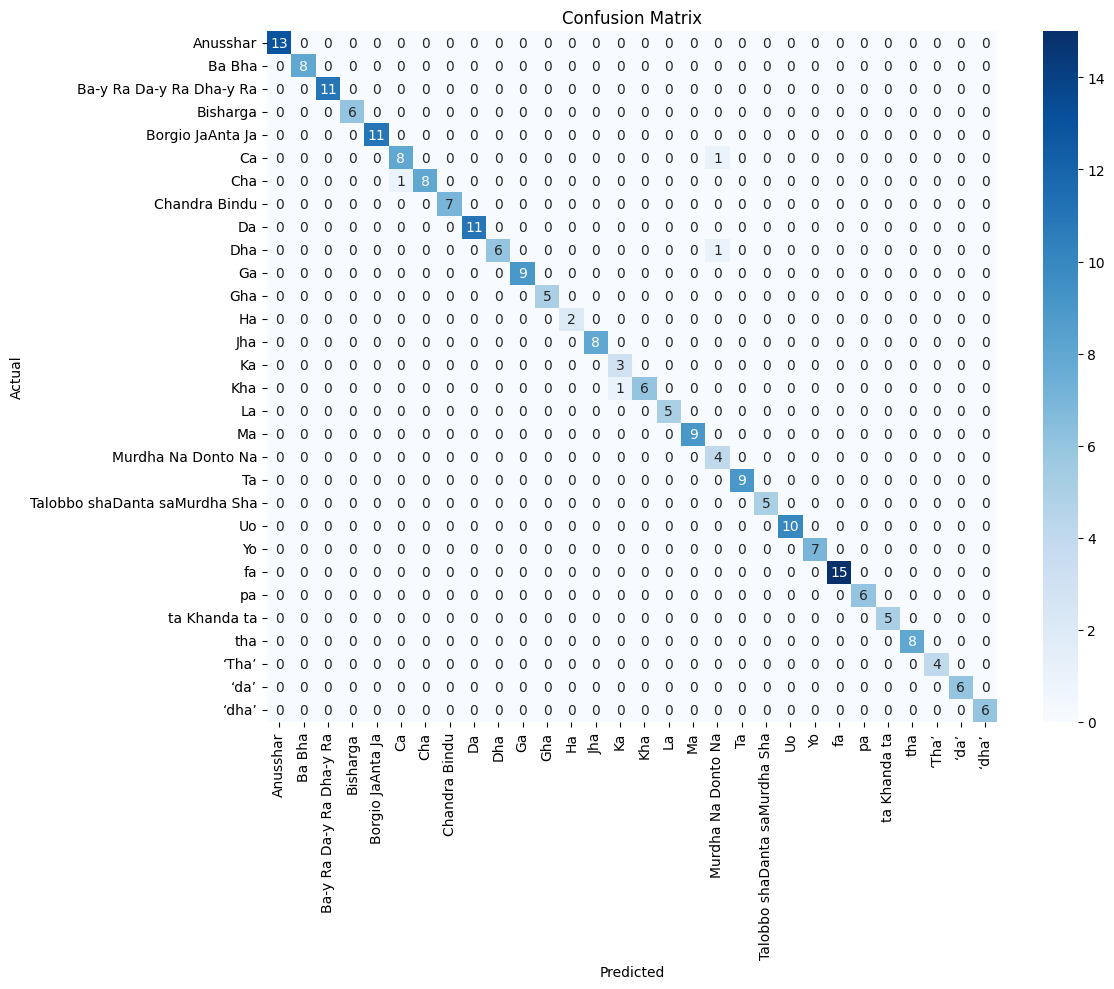

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "C:\\Users\\AJ\\PycharmProjects\\PythonProject\\USLD"  # Path to the USLD folder

#  Transform with augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augment data by flipping images
    transforms.RandomRotation(15),  # Random rotation of images
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

#  Split dataset (70% train, 15% val, 15% test)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

#  Dataloaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

#  Load ResNet50 and add Dropout
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze base

# Adding Dropout layer to prevent overfitting
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Dropout with 50% probability
    nn.Linear(512, num_classes)
)
model = model.to(device)

#  Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

#  Track loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

#  Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loss and accuracy
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

#  Save model
torch.save(model.state_dict(), "bdsl_resnet50_with_dropout.pth")

#  Plot loss and validation curve
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Plot accuracy curve
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Test Accuracy & Classification
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"\nTest Accuracy: {acc:.2f}%\n")

#  Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
